<a href="https://colab.research.google.com/github/brandonb1121/personalprojects/blob/main/DataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -qq install libgeos-dev
!pip install basemap
!wget https://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_20m.zip
!unzip cb_2016_us_county_20m.zip -d counties
!rm cb_2016_us_county_20m.zip
!ls counties/

--2022-03-11 07:34:49--  https://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_20m.zip
Resolving www2.census.gov (www2.census.gov)... 23.6.107.141, 2600:1409:12:286::208c, 2600:1409:12:2b9::208c
Connecting to www2.census.gov (www2.census.gov)|23.6.107.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cb_2016_us_county_20m.zip’

cb_2016_us_county_2     [ <=>                ] 858.91K  --.-KB/s    in 0.05s   

2022-03-11 07:34:49 (16.5 MB/s) - ‘cb_2016_us_county_20m.zip’ saved [879522]

Archive:  cb_2016_us_county_20m.zip
replace counties/cb_2016_us_county_20m.shp.ea.iso.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace counties/cb_2016_us_county_20m.shp.iso.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace counties/cb_2016_us_county_20m.shp.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace counties/cb_2016_us_county_20m.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace counties/cb_2016_us_county_

In [2]:
import pandas as pd
import requests
import re
from osgeo import ogr
from google.colab import drive
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

drive.mount('/content/drive')
path1 = '/content/drive/My Drive/df_snowfall.csv'
path2 = '/content/drive/My Drive/df_stations.csv'
path3 = '/content/drive/My Drive/df_ca_resorts.csv'

df_snowfall = df = pd.read_csv(path1)
df_stations = df = pd.read_csv(path2)
df_ca_resorts = df = pd.read_csv(path3)
df_snowfall.drop("Unnamed: 0", axis=1, inplace=True)
df_stations.drop("Unnamed: 0", axis=1, inplace=True)
df_ca_resorts.drop("Unnamed: 0", axis=1, inplace=True)
#Have to make minor cleaning adjustments for a column since it was acting up in the other CoLab
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
df_snowfall['1_wk_ago']=df_snowfall['1_wk_ago'].apply(lambda cw : remove_tags(cw))
df_snowfall['1_wk_ago'] = pd.to_numeric(df_snowfall['1_wk_ago'].str.replace(r'\D', ''))/10

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: The default value of regex will change from True to False in a future version.


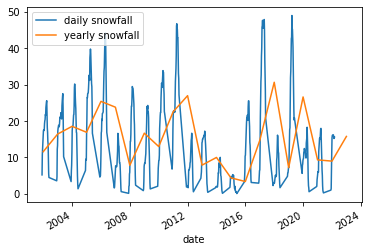

In [3]:
#Plot of weekly snowfall and yearly snowfall from 2001-2022
df_merged = df_snowfall.merge(df_stations, on=["station_id"])
df_merged["year"] = df_merged["date"].str[:4]
df_merged["date"] = pd.to_datetime(df_merged["date"], format="%Y-%m-%d")
df_daily = pd.DataFrame(df_merged.groupby("date")["daily snowfall"].mean())
df_daily.set_index([pd.to_datetime(df_daily.index, format="%Y-%m-%d")], inplace=True)
df_daily.plot.line()
df_merged.groupby([pd.Grouper(key='date', freq='Y')])["daily snowfall"].mean().plot.line(label="yearly snowfall", legend=True)

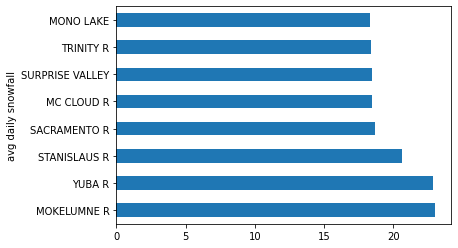

In [4]:
# Which rivers in California experiences the heaviest snowfall on average?
df_merged.groupby("river_basin")["daily snowfall"].mean().sort_values(ascending=False).head(8).plot(kind="barh", xlabel="avg daily snowfall")

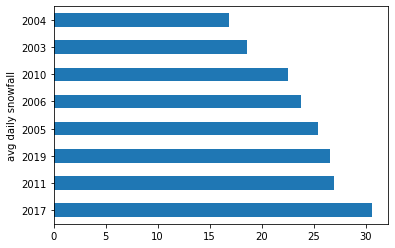

In [5]:
# Which years did California get the most snow?
df_merged.groupby("year")["daily snowfall"].mean().sort_values(ascending=False).head(8).plot(kind="barh", xlabel="avg daily snowfall")

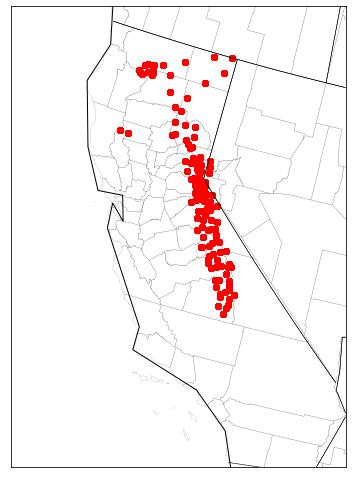

In [6]:
# Plot of all the stations in the dataset
plt.figure(figsize=(6, 12))
m = Basemap(llcrnrlon=-123, llcrnrlat=31, urcrnrlon=-117, urcrnrlat=43.9,
            projection="lcc", lat_1=33, lat_2=45, lon_0=-95)
m.drawstates()
m.drawcoastlines()
m.drawcounties()
m.drawcountries()
m.scatter(df_merged["longitude"], df_merged["latitude"], 
          latlon=True, c="r",
          s=35)
plt.show()

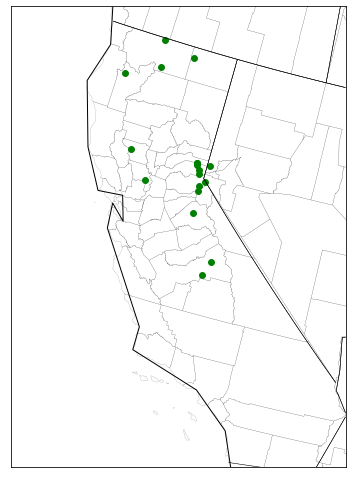

In [7]:
# Plot of all the California ski resorts
plt.figure(figsize=(6, 12))
m = Basemap(llcrnrlon=-123, llcrnrlat=31, urcrnrlon=-117, urcrnrlat=43.9,
            projection="lcc", lat_1=33, lat_2=45, lon_0=-95)
m.drawstates()
m.drawcoastlines()
m.drawcounties()
m.drawcountries()
m.scatter(df_ca_resorts["lon"], df_ca_resorts["lat"], 
          latlon=True, c="g",
          s=35)
plt.show()

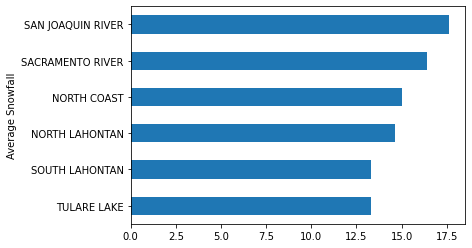

In [8]:
# Average snowfall by hydrologic area
df_merged.groupby("hydrologic_area")["daily snowfall"].mean().sort_values().plot(kind="barh", xlabel="Average Snowfall")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


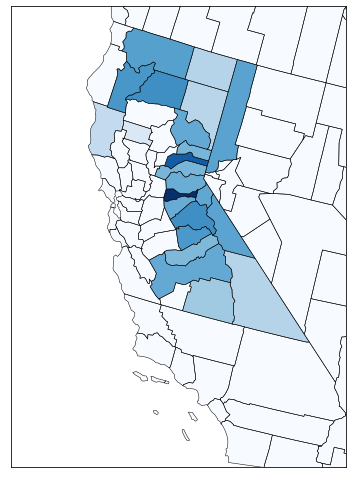

In [10]:
# Chloropleth of average snowfall by county
# Replacing all county values where "State of Nevada" is now Washoe county
# All stations located in Nevada are in Washoe county
df_merged.loc[df_merged["county"] == "State of Nevada", "county"] = "WASHOE"
df_county = df_merged[["daily snowfall", "county"]]
df_county["lowercase county"] = df_county["county"].str.title()
county_snowfall = df_county.groupby("lowercase county")["daily snowfall"].mean().to_frame()
df_counties = pd.DataFrame(m.counties_info)
df_counties_snowfall = df_counties.merge(county_snowfall, left_on=["NAME"],
                  right_on=["lowercase county"], how="left")
df_counties_snowfall["daily snowfall"] = df_counties_snowfall["daily snowfall"].fillna(0)
plt.figure(figsize=(6, 12))
m = Basemap(llcrnrlon=-123, llcrnrlat=31, urcrnrlon=-117, urcrnrlat=43.9,
            projection="lcc", lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile("counties/cb_2016_us_county_20m", "counties")
polygons = [mpl.patches.Polygon(vertices) for vertices in m.counties]
collection = mpl.collections.PatchCollection(polygons, cmap="Blues")
collection.set_array(df_counties_snowfall["daily snowfall"])
ax = plt.gca()
ax.add_collection(collection)
# White color means no information is present in these counties